In [6]:
!pwd
!pip list | grep pandas

/workspace/CarND-Behavioral-Cloning-P3
DEPRECATION: The default format will switch to columns in the future. You can use --format=(legacy|columns) (or define a format=(legacy|columns) in your pip.conf under the [list] section) to disable this warning.
pandas (0.23.0)
You are using pip version 9.0.3, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
root_path = '../'
project_path = root_path + 'CarND-Behavioral-Cloning-P3/'
model_path = project_path + 'model/'
data_path = project_path + 'data/'

In [4]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import pandas as pd
# import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import tensorflow as tf
from tensorflow.contrib.layers import flatten
from tensorflow import keras
from keras.models import Sequential, Model
from keras.layers import Cropping2D
import cma
import sys
import os
import math
import glob
import csv

# Visualizations will be shown in the notebook.
%matplotlib inline

Using TensorFlow backend.


### Load training/testing/validation data

In [7]:
class DataList:
    def __init__(self):
        # self.images = None
        self.X_train = None
        self.y_train = None
        self.X_valid = None
        self.y_valid = None
        self.X_test = None
        self.y_test = None
    
    def load_data(self):
        # data_list = glob.glob(data_path + 'IMG/*')
        # # for i in range(len(data_list)):
        # images = []
        # for i in range(10):
        #     img = mpimg.imread(data_list[i])
        #     images.append(img)
        # self.images = np.asarray(images)
        def strip(text):
            try:
                return text.strip()
            except AttributeError:
                return text

        def make_float(text):
            return float(text)

        df = pd.read_csv(data_path + 'driving_log.csv',
                         sep=',',
                         converters = {'center': strip,
                                       'left': strip,
                                       'right': strip}
                        )
        X = np.array(df['center'].tolist())
        left_X = np.array(df['left'].tolist())
        right_X = np.array(df['right'].tolist())
        y = np.array(df['steering'].tolist())
        left_y = self.steering_transform(np.array(df['steering'].tolist()), left=True)
        right_y = self.steering_transform(np.array(df['steering'].tolist()), left=False)
        X = np.concatenate((X, left_X, right_X))
        y = np.concatenate((y, left_y, right_y))
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
        X_test, X_valid, y_test, y_valid = train_test_split(X_test, y_test, test_size=0.5)
        self.X_train, self.X_test, self.X_valid = X_train, X_test, X_valid
        self.y_train, self.y_test, self.y_valid = y_train, y_test, y_valid
        # print('X[51:54]: {}, shape: {}'.format(right_X[51:54], X.shape))
        # print('fucking path: {}'.format(data_path + right_X[51]))
        # print('left_X[51:54]: {}, shape: {}'.format(left_y[51:54], left_X.shape))
        # print('right_X[51:54]: {}, shape: {}'.format(right_y[51:54], right_X.shape))
        # print('y[0:4]: {}, shape: {}'.format(y[0:4], y.shape))
        # print('X, type: {}'.format(type(X)))
        # print('X_train, shape: {}'.format(X_train.shape))
        # print('X_test, shape: {}'.format(X_test.shape))
        # print('X_valid, shape: {}'.format(X_valid.shape))
        # print('y_train, shape: {}'.format(y_train.shape))
        # print('y_test, shape: {}'.format(y_test.shape))
        # print('y_valid, shape: {}'.format(y_valid.shape))
        # print('right_X, shape: {}'.format(right_X.shape))
        # print('y, shape: {}'.format(y.shape))

    def data_augmentation(self):
        pass

    def steering_transform(self, y, left=True):
        correction = 0.2
        if left == True:
            y += correction
        else:
            y -= correction
        return y

data_list = DataList()
data_list.load_data()
# print('images shape: {}'.format(data_list.images.shape))

### Generator
Here is an example of how you could use a generator to load data and preprocess it on the fly, in batch size portions to feed into your Behavioral Cloning model.

In [8]:
def generator(X, y, batch_size=32):
    data_size = X.shape[0]
    while 1: # Loop forever so the generator never terminates
        X, y = shuffle(X, y)
        for offset in range(0, data_size, batch_size):
            X_batch = X[offset:offset+batch_size]

            images = []
            for each in X_batch:
                # print('each: {}'.format(each))
                # print('fucking path: {}'.format(data_path + each))
                img = mpimg.imread(data_path + each)
                images.append(img)
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = y[offset:offset+batch_size]
            # TODO: Do some image augmentation here.
            # yield sklearn.utils.shuffle(X_train, y_train)
            yield X_train, y_train

# Set our batch size
batch_size = 32

# compile and train the model using the generator function
train_generator = generator(data_list.X_train, data_list.y_train, batch_size=batch_size)
test_generator = generator(data_list.X_test, data_list.y_test, batch_size=batch_size)
valid_generator = generator(data_list.X_valid, data_list.y_valid, batch_size=batch_size)
train_step = math.ceil(data_list.X_train.shape[0] / batch_size)
test_step = math.ceil(data_list.X_test.shape[0] / batch_size)
valid_step = math.ceil(data_list.X_valid.shape[0] / batch_size)

### Using Keras to build PilotNet

![PilotNet](https://i0.wp.com/syncedreview.com/wp-content/uploads/2017/05/screen-shot-2017-05-12-at-11-25-28-pm.png?resize=950%2C869&ssl=1)

The convolutional layers were designed to perform feature extraction and were chosen empirically through a series of experiments that varied layer configurations. We use strided convolutions in the first three convolutional layers with a 2x2 stride and a 5x5 kernel and a non-strided convolution with a 3x3 kernel size in the last two convolutional layers.

In [22]:
class PilotNet:
    def __init__(self):
        self.model = None
        

    def build_model(self):
        def resize(images):
            return tf.image.resize_area(images, size=(66, 200))
        
        def preprocessing(images):
            # images = tf.image.rgb_to_yuv(images)
            return tf.map_fn(lambda img: tf.image.per_image_standardization(img), images)


        inputs = keras.Input(shape=(160, 320, 3), name='inputs')
        cropping = keras.layers.Cropping2D(cropping=((50, 20), (0, 0)), name='cropping')(inputs)
        resize = keras.layers.Lambda(resize, name='resize')(cropping)
        norm = keras.layers.Lambda(preprocessing, name='normalization')(resize)
        # input = (66, 200, 3), output = (31, 98, 24)
        conv_1 = keras.layers.Conv2D(filters=24,
                                     kernel_size=5,
                                     strides=2,
                                     padding='valid',
                                     activation='relu',
                                     name='conv_1')(norm)
        # input = (31, 98, 24), output = (14, 47, 36)
        conv_2 = keras.layers.Conv2D(filters=36,
                                     kernel_size=5,
                                     strides=2,
                                     padding='valid',
                                     activation='relu',
                                     name='conv_2')(conv_1)
        # input = (14, 47, 36), output = (5, 22, 48)
        conv_3 = keras.layers.Conv2D(filters=48,
                                     kernel_size=5,
                                     strides=2,
                                     padding='valid',
                                     activation='relu',
                                     name='conv_3')(conv_2)
        # input = (5, 22, 48), output = (3, 20, 64)
        conv_4 = keras.layers.Conv2D(filters=64,
                                     kernel_size=3,
                                     strides=1,
                                     padding='valid',
                                     activation='relu',
                                     name='conv_4')(conv_3)
        # input = (3, 20, 64), output = (1, 18, 64)
        conv_5 = keras.layers.Conv2D(filters=64,
                                     kernel_size=3,
                                     strides=1,
                                     padding='valid',
                                     activation='relu',
                                     name='conv_5')(conv_4)
        # input = (1, 18, 64), output = (1152,)
        flatten = keras.layers.Flatten(name='flatten')(conv_5)
        # input = (1152,), output = (100,)
        dense_1 = keras.layers.Dense(units=100,
                                     activation='relu',
                                     name='dense_1')(flatten)
        # input = (100,), output = (50,)
        dense_2 = keras.layers.Dense(units=50,
                                     activation='relu',
                                     name='dense_2')(dense_1)
        # input = (50,), output = (10,)
        dense_3 = keras.layers.Dense(units=10,
                                     activation='relu',
                                     name='dense_3')(dense_2)
        # input = (10,), output = (1,)
        outputs = keras.layers.Dense(units=1,
                                     activation='relu',
                                     name='outputs')(dense_3)


        # set up cropping2D layer
        self.model = keras.Model(inputs=inputs, outputs=outputs)
        self.model.compile(optimizer=tf.keras.optimizers.Adam(0.01),
                           loss='categorical_crossentropy',
                           metrics=['accuracy'])
        
    def predict_generator(self, generator, steps):
        result = self.model.predict_generator(generator=generator, steps=steps)
        return result

pilot_net = PilotNet()
pilot_net.build_model()

### Output model structure image

In [ ]:
tf.keras.utils.plot_model(
    pilot_net.model,
    to_file='pilot_net.png',
    show_shapes=True,
    show_layer_names=True,
    rankdir='TB'
)

In [15]:
crop_img = pilot_net.predict_generator(valid_generator, valid_step)
print('crop_img type: {}, shape: {}'.format(type(crop_img), crop_img.shape))

crop_img type: <class 'numpy.ndarray'>, shape: (3617, 66, 200, 3)


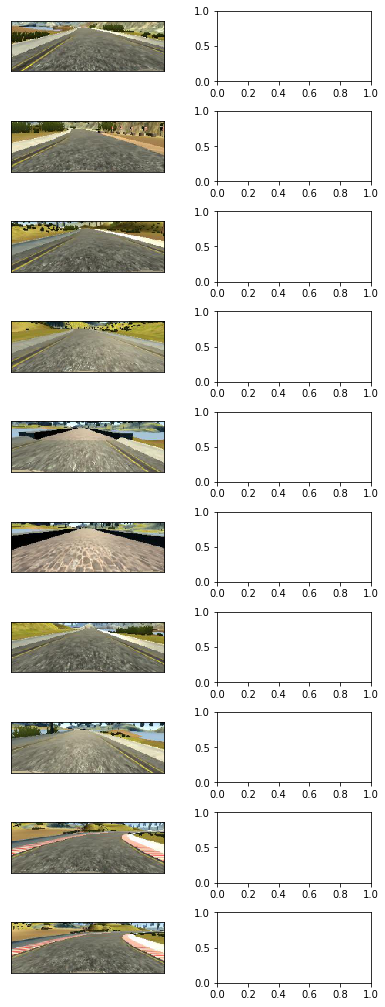

In [17]:
id = 0
f, axis = plt.subplots(10, 2, figsize=(5, 15))
f.tight_layout()
# f.suptitle('Random choose image from each class', fontsize=16)
for row in range(10):
    for col in range(1):
        axis[row][col].imshow(crop_img[id].astype(np.uint8))
#         axis[row][col+1].imshow(datas.images[id].astype(np.uint8))
        id += 1
        axis[row][col].get_xaxis().set_visible(False)
#         axis[row][col+1].get_xaxis().set_visible(False)
        axis[row][col].get_yaxis().set_visible(False)
#         axis[row][col+1].get_yaxis().set_visible(False)

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()
plt.close()